In [1]:
import numpy as np
import pandas as pd
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import spacy
from spacy import displacy
from cleantext import clean
import xgboost as xgb

# Lemmatizing libraries
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.corpus import stopwords
nltk.download('stopwords');


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/william/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[how to get latest file](https://stackoverflow.com/questions/39327032/how-to-get-the-latest-file-in-a-folder)

In [2]:
list_of_files = glob.glob('./scitech_data_scraped/*.csv') #
latest_file = max(list_of_files, key=os.path.getctime)

In [3]:
sci_tech_data = pd.read_csv(latest_file)

/Users/william/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (17,21,34,63,68,112) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Below I drop duplicate rows.

In [4]:
sci_tech_data.drop_duplicates(subset = ['selftext','title'], inplace=True)

Below I select the relevent rows that have tech or science as the subreddits and save the feature space, 'title' and the target, 'subreddit' to respective variables.

In [5]:
sci_tech_data['subreddit_name_prefixed'].value_counts()

r/technology              6692
r/science                 3165
u/MEGA-Technology          193
u/Ok-Technology-1912       142
u/Candid-Science-7189      132
u/Gold-Science-2230         94
u/Away-Technology-4883      63
u/Any-Technology-9975       61
u/Dazzling-Science-652      34
u/AVID-Technology           30
u/Content-Technology-7      19
u/Bugd-Technology            7
u/kretoss-technology         5
u/SecureAge-Technology       4
u/Thin-Science-6996          3
u/OV-Technology              3
u/Slow-Technology-9949       3
u/Ok-Science-1826            2
u/FS-Technology              2
u/A-science-enthusiast       2
u/Efficient-Science-80       1
u/Ok-Science-9480            1
u/No-Technology-2687         1
u/Jaded-Technology-332       1
u/more-technology-00         1
u/Dear-Technology-6015       1
u/Then-Technology-9558       1
u/MR-Technology              1
u/Fearless-Science-103       1
u/Worth-Science-4441         1
u/awesome-technology         1
u/visimens-technology        1
u/Fearle

In [6]:
subreddit = sci_tech_data.loc[(sci_tech_data['subreddit'].isin(
                                ['technology','science']), 'subreddit')]
title = sci_tech_data.loc[(sci_tech_data['subreddit'].isin(
                                ['technology','science']),'title')]

In [7]:
X = title
y = subreddit

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

I'll get POS counts on the raw data.
[dict to df](https://sparkbyexamples.com/python/pandas-convert-list-of-dictionaries-to-dataframe/#:~:text=The%20from_records()%20method%20is,dicts%20%2C%20or%20from%20another%20DataFrame.); 
[spacy POS tagging](https://machinelearningknowledge.ai/tutorial-on-spacy-part-of-speech-pos-tagging/); [spacy POS tagging #2](https://www.geeksforgeeks.org/python-pos-tagging-and-lemmatization-using-spacy/)

In [47]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp(u"The quick brown fox jumped over the lazy dog's back.")

# Counting the frequencies of different fine-grained tags:
TAG_counts = doc.count_by(spacy.attrs.TAG)

print(TAG_counts)
for k,v in sorted(TAG_counts.items()):
    print(f'{k}. {doc.vocab[k].text:{4}}: {v}')

{15267657372422890137: 2, 10554686591937588953: 3, 15308085513773655218: 2, 17109001835818727656: 1, 1292078113972184607: 1, 74: 1, 164681854541413346: 1, 12646065887601541794: 1}
74. POS : 1
164681854541413346. RB  : 1
1292078113972184607. IN  : 1
10554686591937588953. JJ  : 3
12646065887601541794. .   : 1
15267657372422890137. DT  : 2
15308085513773655218. NN  : 2
17109001835818727656. VBD : 1


In [55]:
nlp = spacy.load("en_core_web_sm")
parts_of_speech = []
for title in X_train:
    tokenized = nlp(title)
    pos_counts = {}
    for token in tokenized:
        if token.pos_ not in pos_counts.keys():
            pos_counts[token.pos_] = 1
        else :
            pos_counts[token.pos_] += 1
    parts_of_speech.append(pos_counts)

In [56]:
pos_keys = []

[{'VERB': 3,
  'DET': 1,
  'NOUN': 3,
  'PUNCT': 1,
  'X': 1,
  'PROPN': 2,
  'PRON': 1,
  'PART': 1,
  'ADP': 2},
 {'NOUN': 4, 'AUX': 1, 'VERB': 1, 'DET': 1, 'ADP': 2, 'ADJ': 1},
 {'DET': 2,
  'PROPN': 2,
  'PUNCT': 2,
  'AUX': 2,
  'NOUN': 3,
  'VERB': 5,
  'ADP': 3,
  'PRON': 2,
  'ADJ': 1,
  'PART': 1,
  'SCONJ': 1},
 {'DET': 1,
  'ADJ': 3,
  'PROPN': 3,
  'NOUN': 4,
  'AUX': 1,
  'ADV': 2,
  'VERB': 3,
  'ADP': 3,
  'SYM': 1,
  'NUM': 4,
  'PART': 2,
  'PUNCT': 1,
  'PRON': 1},
 {'PROPN': 9, 'NUM': 2, 'PUNCT': 5},
 {'ADJ': 1, 'NOUN': 5, 'PROPN': 2, 'PUNCT': 1},
 {'NOUN': 5, 'VERB': 2, 'PROPN': 2, 'AUX': 1, 'PART': 1},
 {'PROPN': 2,
  'NOUN': 7,
  'VERB': 3,
  'PUNCT': 2,
  'ADJ': 5,
  'ADP': 2,
  'AUX': 1,
  'ADV': 1,
  'CCONJ': 1},
 {'NUM': 1, 'PROPN': 5, 'PUNCT': 1, 'NOUN': 1},
 {'PROPN': 7, 'VERB': 2, 'PART': 1, 'PUNCT': 1, 'NOUN': 1},
 {'PRON': 3,
  'AUX': 3,
  'ADV': 2,
  'ADP': 2,
  'PROPN': 3,
  'CCONJ': 1,
  'VERB': 7,
  'DET': 7,
  'NOUN': 7,
  'ADJ': 2,
  'PUNCT': 4,
  '

[source: strip characters from string in series](https://stackoverflow.com/questions/13682044/remove-unwanted-parts-from-strings-in-a-column)
[source: remove punctuation](https://www.google.com/search?q=how+to+replace+punctuation+with+regular+expression+python&rlz=1C5CHFA_enUS983US983&oq=how+to+replace+punctuation+with+regular&aqs=chrome.1.69i57j33i160l2.10574j0j7&sourceid=chrome&ie=UTF-8#kpvalbx=_7SabY4OANaSs0PEP042roAM_32)

Get rid of puctuation

[remove stop words](https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe)

In [9]:
stop_words = stopwords.words('english')
stop_words;

In [10]:
def filtered(data):
    # replace "-" w/ 'hyphen', then remove emojis, punctuation, digits, and urls
    # while keeping an indicator or url usage.
    data_filtered = data.map(lambda x: clean(
                            re.sub('-',repl=' hyphen ', string = x) , no_emoji=True,
                                no_punct=True,no_digits=True, no_urls=True))

    # remove leftovers from the 'clean' function  

    data_filtered = data_filtered.map(lambda x: re.sub('(0|\|)',
                                                    repl='',string = x))
    #replacing hyphen with '-'
    data_filtered = data_filtered.map(lambda x: re.sub('hyphen',repl='-', string = x))
    # remove stop words   
    data_filtered = data_filtered.map(lambda x: ' '.join([word for word 
                                              in x.split() if word not in 
                                              stop_words]))
    return data_filtered

In [11]:
X_test_filtered = filtered(X_test)

In [12]:
# replace "-" w/ 'hyphen', then remove emojis, punctuation, digits, and urls
# while keeping an indicator or url usage.

X_train_filtered = X_train.map(lambda x: clean(
                            re.sub('-',repl=' hyphen ', string = x) , no_emoji=True,
                                no_punct=True,no_digits=True, no_urls=True))

# remove leftovers from the 'clean' function  

X_train_filtered = X_train_filtered.map(lambda x: re.sub('(0|\|)',
                                                    repl='',string = x))
#replacing hyphen with '-'
X_train_filtered = X_train_filtered.map(lambda x: re.sub('hyphen',repl='-', string = x))
# remove stop words   
X_train_filtered = X_train_filtered.map(lambda x: ' '.join([word for word 
                                          in x.split() if word not in 
                                          stop_words]))

print((sum([len(s) for s in X_train])-sum([len(s) for s in X_train_filtered]))
    /sum([len(s) for s in X_train])
)

# I'll keep (<url>) group in the words, in case there is differential frequency

0.22357637818276238


###### **Lemmatization** -- [sources](https://www.machinelearningplus.com/nlp/lemmatization-examples-python/)

In [13]:
lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/william/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

[Lemmatizing w/ POS](https://www.machinelearningplus.com/nlp/lemmatization-examples-python/)

In [14]:
# Lemmatize with POS Tag

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

To-do/idea: get POS counts [source](https://stackoverflow.com/questions/20960777/python-how-to-count-pos-tags-from-from-a-sentence)

In [15]:
lemmatizer = WordNetLemmatizer()

X_train_lemmatized = []
for title in X_train_filtered:
    X_train_lemmatized.append(' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for \
                               w in nltk.word_tokenize(title)]))
X_train_lemmatized;

In [16]:
X_train_lemmatized = pd.Series(data = X_train_lemmatized, index = X_train_filtered.index)

In [17]:
X_test_lemmatized = []
for title in X_test_filtered:
    X_test_lemmatized.append(' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for \
                               w in nltk.word_tokenize(title)]))
X_test_lemmatized;

['traffic related air pollution associate increase likelihood multiple long - term physical mental health condition research people found simple measure reduce traffic level could potentially improve life lessen pressure healthcare system',
 'twitter engineer fire twitter call musk team bunch coward',
 'canine brain wiring influence human - driven breeding practice study show',
 'naacp adl orgs call advertiser boycott twitter',
 'poweriso crack + registration code free',
 'binance ceo say hold dont buy crypto',
 'meta sue psbn ethiopia hate speech reveal bureau xpost rbamevoicesuk',
 'decline text - base social medium',
 'best buy customer give retailer buy new pixel google',
 'elon musk lie credential year',
 'twitter suspends elonjet musk promise ban',
 'few parent chose high - add sugar beverage package displayed warning teaspoon add sugar disclosure reduce add sugar calorie chosen beverage respectively',
 'create beautiful productivity chrome browser page nasa astronomy picture day

In [19]:
# back to DataFrame
df = pd.DataFrame(X_train_lemmatized, columns = ['title']).join(pd.DataFrame(y_train))

In [20]:
df_test = pd.DataFrame(X_test_lemmatized, columns = ['title']).join(pd.DataFrame(y_train))

In [21]:
df.index = range(df.shape[0])

###### With words lemmatized and english stop words removed I will proceed with EDA

Below I will inspect various distributions of title statistics after adding the statistics to the dataframe.

In [22]:
df['title_length'] = [len(df.loc[i,'title']) for i in range(len(df['title']))]

In [23]:
df['title_word_count'] = [len(df.loc[i,'title'].split(' ')) for i in range(len(df['title']))]

In [24]:
df['max_word_length'] = [max(map(len, title.split(' '))) \
                         for title in df['title']] 

In [25]:
df['avg_word_length'] = df['title_length']/df['title_word_count']

In [26]:
df['subreddit_indicator']=[1 if sub == 'technology' else 0 for sub in df['subreddit']]

In [27]:
import seaborn as sns

[Text(0.5, 1.0, 'Distribution of title word counts by subreddit')]

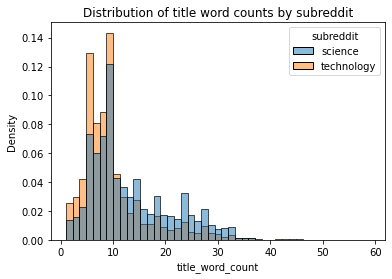

In [28]:
sns.histplot(data = df, x = 'title_word_count', hue = 'subreddit', stat='density', common_norm = False, bins = 45).set(title = 'Distribution of title word counts by subreddit')

Above we can see that shorter titles have a better chance of having been posted to technology, while longer titles are more likely from science even after accounting for baseline frequencies.

Above we see that there are many posts between 0 and 20 words long with a 

[Text(0.5, 1.0, 'Distribution of title character length by subreddit')]

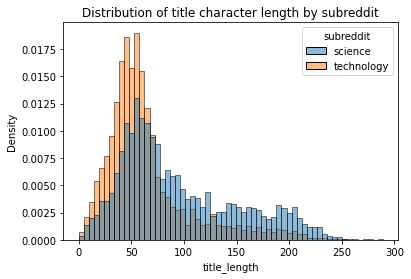

In [29]:
sns.histplot(data = df, x = 'title_length', hue = 'subreddit', stat='density', common_norm = False).set(title = 'Distribution of title character length by subreddit')

Above we see that generally title character lengths under around 80 are more likely to have been from technology, and above 80 from science.

[Text(0.5, 1.0, 'Distribution of title word counts by subreddit'), (4.0, 11.0)]

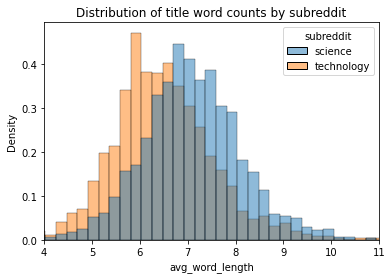

In [30]:
sns.histplot(data = df, x = 'avg_word_length', hue = 'subreddit', 
             stat='density', bins = 100, common_norm = False).set(
    title = 'Distribution of title word counts by subreddit', xlim = [4,11])

[adjusting bins](https://stackoverflow.com/questions/48990594/how-to-draw-distribution-plot-for-discrete-variables-in-seaborn)

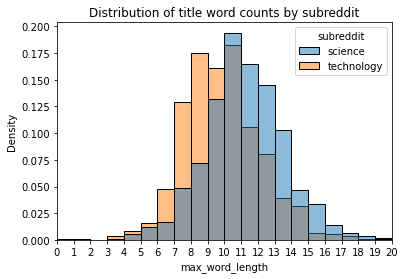

In [31]:
sns.histplot(data = df, x = 'max_word_length', hue = 'subreddit', 
             stat='density', common_norm = False, bins=np.arange(0,21)).set(
    title = 'Distribution of title word counts by subreddit', xlim = [0,20], 
    xticks = range(0,21));

In [32]:
df.corr()

,title_length,title_word_count,max_word_length,avg_word_length,subreddit_indicator
title_length,1.000000,0.965403,0.461224,0.211614,-0.283340
title_word_count,0.965403,1.000000,0.345098,0.010603,-0.212127
max_word_length,0.461224,0.345098,1.000000,0.620346,-0.214625
avg_word_length,0.211614,0.010603,0.620346,1.000000,-0.243823
subreddit_indicator,-0.283340,-0.212127,-0.214625,-0.243823,1.000000


Above we see that word length, character count, and word counts all have some correlation with the particular subredit, though the correlation is not strong.  However, from the density plots and the clear separation in likelihoods it is apparent that valuable information would likely be picked up from a tree-based classification model.  It is promising that the title statistics gathered thus far are not fully correlated with each other as this means they can provide non-redundant information to the modeling process.

I'll next look at word count frequencies

[Text(0.5, 1.0, '15 most common words word count -- technology')]

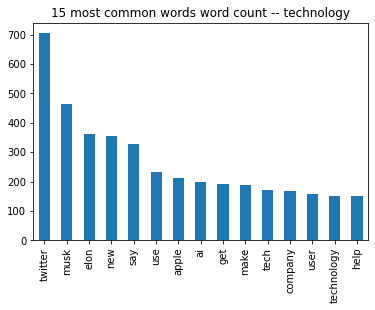

In [33]:
cv = CountVectorizer()
vectors = cv.fit_transform(df[df['subreddit']=='technology']['title'])
vectors.A
wc_vec = pd.DataFrame(vectors.A, columns = cv.get_feature_names_out())
wc_vec.sum().sort_values(ascending = False)[0:15].plot(kind = 'bar')\
.set(title = '15 most common words word count -- technology')

[Text(0.5, 1.0, '15 most common words word count -- science')]

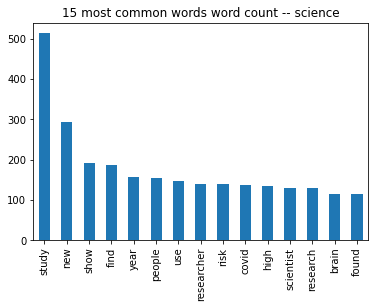

In [34]:
cv = CountVectorizer()
vectors = cv.fit_transform(df[df['subreddit']=='science']['title'])
vectors.A
wc_vec = pd.DataFrame(vectors.A, columns = cv.get_feature_names_out())
wc_vec.sum().sort_values(ascending = False)[0:15].plot(kind = 'bar')\
.set(title = '15 most common words word count -- science')

Above we see that there is not much overlap within the 15 most common words.  This indicates that there is a good chance that these common words will help with distinguishing between the subreddits.  Of note is that proper nouns seem to feature heavily in technology and almost not at all in science.

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [36]:
tfidf_vec = TfidfVectorizer(stop_words='english', max_features=1_000,
                             ngram_range=(1,2))
logreg = LogisticRegression(penalty='elasticnet', max_iter=10_000, \
                            random_state=1)

In [37]:
tfidf_lr_params = {"logreg__C": [.1,1,10],
                    "logreg__l1_ratio": [.1,.5,.9],
                   'tfidf_vec__max_df': [.9,.95,1.0],
                   'tfidf_vec__min_df': [.001,.003]}

In [38]:

tfidf_lr_pipe = Pipeline([
    ('tfidf_vec', tfidf_vec),
    ('logreg', LogisticRegression(penalty='none', max_iter=10_000, random_state=33))
])

In [39]:
gs_tfidf_lr = GridSearchCV(tfidf_lr_pipe,tfidf_lr_params)

In [40]:
df.shape, y_train.shape

((7392, 7), (7392,))

In [41]:
df.columns

Index(['title', 'subreddit', 'title_length', 'title_word_count',
       'max_word_length', 'avg_word_length', 'subreddit_indicator'],
      dtype='object')

In [42]:
gs_tfidf_lr.fit(df['title'],y_train)

/Users/william/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
/Users/william/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/william/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
/Users/william/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/william/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warning

KeyboardInterrupt: 

In [ ]:
gs_tfidf_lr.score(df['title'],y_train),gs_tfidf_lr.score(df['title'],y_train)

In [ ]:
gs_tfidf_lr.score(X_test_lemmatized,y_test)

In [ ]:
tfidf_xgb_pipe = Pipeline([
    ('tfidf_vec', tfidf_vec),
    ('xgb', xgb.XGBClassifier())])
tfidf_xgb_params = {"xgb__eta": [.01,.03],
                    'xgb__booster': ['gbtree','gblinear'],
                   'tfidf_vec__max_df': [.9,.95,1.0],
                   'tfidf_vec__min_df': [.001,.003]}
gs_tfidf_xgb = GridSearchCV(tfidf_xgb_pipe,tfidf_xgb_params)

In [ ]:
y_train_xgb = [1 if sub == 'technology' else 0 for sub in y_train]
y_test_xgb = [1 if sub == 'technology' else 0 for sub in y_test]


In [ ]:
# gs_tfidf_xgb.fit(X_train_lemmatized,y_train_xgb)

In [ ]:
gs_tfidf_xgb.score(X_train_lemmatized,y_train_xgb),gs_tfidf_xgb.score(X_test_lemmatized,y_test_xgb)

In [ ]:
gs_tfidf_xgb = GridSearchCV(tfidf_xgb_pipe,{'tfidf_vec__max_df': [0.9],
 'tfidf_vec__min_df': [0.001],
 'xgb__booster': ['gblinear'],
 'xgb__eta': [0.01]})

 

In [ ]:
# gs_tfidf_xgb.fit(X_train_lemmatized,y_train_xgb)
gs_tfidf_xgb.score(X_train_lemmatized,y_train_xgb),gs_tfidf_xgb.score(X_test_lemmatized,y_test_xgb)

In [ ]:
gs_tfidf_xgb.best_params_

param choices:
tfidf_xgb_params = {"xgb__eta": [.01,.03],
                    'xgb__booster': ['gbtree','gblinear'],
                   'tfidf_vec__max_df': [.9,.95,1.0],
                   'tfidf_vec__min_df': [.001,.003]}
score: 

(0.9143668831168831, 0.8892494929006085)

gs_tfidf_xgb.best_params_ :

{'tfidf_vec__max_df': 0.9,
 'tfidf_vec__min_df': 0.001,
 'xgb__booster': 'gblinear',
 'xgb__eta': 0.01}
 

So far xgboost has provided the best prediction on the test set.  I will try to narrow in on the best parameters.

In [ ]:
tfidf_xgb_pipe = Pipeline([
    ('tfidf_vec', tfidf_vec),
    ('xgb', xgb.XGBClassifier(seed = 1))])
tfidf_xgb_params = {"xgb__eta": [.01,.015,.05],
                    'xgb__booster': ['gbtree','gblinear'],
                    # 'xgb__lambda': [.1,1,10],
                    # 'xgb__alpha': [0,.1,1],
                   'tfidf_vec__max_df': [.85,.9,.925],
                   'tfidf_vec__min_df': [.0005,.001,.0015],}
gs_tfidf_xgb = GridSearchCV(tfidf_xgb_pipe,tfidf_xgb_params)

In [ ]:
# gs_tfidf_xgb.fit(X_train_lemmatized,y_train_xgb)

In [ ]:
gs_tfidf_xgb.best_params_

In [ ]:
gs_tfidf_xgb.best_params_
{'tfidf_vec__max_df': 0.85,
 'tfidf_vec__min_df': 0.001,
 'xgb__alpha': 0,
 'xgb__booster': 'gbtree',
 'xgb__eta': 0.05,
 'xgb__lambda': 0.1}


In [ ]:
gs_tfidf_xgb.score(X_train_lemmatized,y_train_xgb),gs_tfidf_xgb.score(X_test_lemmatized,y_test_xgb)

In [ ]:
# gs_tfidf_xgb.fit()

In [ ]:
gs_tfidf_xgb = GridSearchCV(tfidf_xgb_pipe,{'tfidf_vec__max_df': [0.9],
 'tfidf_vec__min_df': [0.001],
 'xgb__booster': ['gblinear'],
 'xgb__eta': [0.005]})

In [ ]:
# gs_tfidf_xgb.fit(X_train_lemmatized,y_train_xgb)
gs_tfidf_xgb.score(X_train_lemmatized,y_train_xgb),gs_tfidf_xgb.score(X_test_lemmatized,y_test_xgb)

In [ ]:
import spacy

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
X_tr